# Sea Ice Extent Timeseries
## **OISST**

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(20)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [3]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.44766899388a4bc283ed20b12f329927 Dashboard: /services/dask-gateway/clusters/staging.44766899388a4bc283ed20b12f329927/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [22]:
client.close()
cluster.close()

In [4]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True)
ds.ice

,Array,Chunk
Bytes,56.13 GiB,79.10 MiB
Shape,"(14532, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,728 Tasks,727 Chunks
Type,float32,numpy.ndarray


In [5]:
ds

,Array,Chunk
Bytes,56.13 GiB,79.10 MiB
Shape,"(14532, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,728 Tasks,727 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,56.13 GiB,79.10 MiB
Shape,"(14532, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,728 Tasks,727 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
ds.lon#.sel(lon=-65, method='nearest')

<xarray.DataArray 'lon' (lon: 1440)>
array([1.25000e-01, 3.75000e-01, 6.25000e-01, ..., 3.59375e+02, 3.59625e+02,
       3.59875e+02], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Attributes:
    grids:      Uniform grid from 0.125 to 359.875 by 0.25
    long_name:  Longitude
    units:      degrees_east

In [7]:
dsr = ds.reset_coords(drop=True).roll(lon=719)

<ipython-input-7-f89cb0314cd0>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  dsr = ds.reset_coords(drop=True).roll(lon=719)


In [8]:
dsr.lon

<xarray.DataArray 'lon' (lon: 1440)>
array([180.375, 180.625, 180.875, ..., 179.625, 179.875, 180.125],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 180.4 180.6 180.9 181.1 ... 179.4 179.6 179.9 180.1
Attributes:
    grids:      Uniform grid from 0.125 to 359.875 by 0.25
    long_name:  Longitude
    units:      degrees_east

In [9]:
west = dsr.lon[:719] -  359.875

In [10]:
dsr.lon[719:]

<xarray.DataArray 'lon' (lon: 721)>
array([1.25000e-01, 3.75000e-01, 6.25000e-01, ..., 1.79625e+02, 1.79875e+02,
       1.80125e+02], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 179.4 179.6 179.9 180.1
Attributes:
    grids:      Uniform grid from 0.125 to 359.875 by 0.25
    long_name:  Longitude
    units:      degrees_east

In [11]:
new_lon = xr.concat([west, dsr.lon[719:]], dim='lon')
new_lon

<xarray.DataArray 'lon' (lon: 1440)>
array([-179.5  , -179.25 , -179.   , ...,  179.625,  179.875,  180.125],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 180.4 180.6 180.9 181.1 ... 179.4 179.6 179.9 180.1

In [12]:
ds = dsr.assign_coords(lon=new_lon)

In [13]:
ds

,Array,Chunk
Bytes,56.13 GiB,79.10 MiB
Shape,"(14532, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,4363 Tasks,727 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,56.13 GiB,79.10 MiB
Shape,"(14532, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,4363 Tasks,727 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [14]:
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'lon', 'left': 'lon_g'}, 
                             'Y': {'center': 'lat', 'left': 'lat_g'},
                             'T': {'center': 'time'},
                             'Z': {'center': 'zlev', 'left': 'zlev_l'}})
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center
T Axis (periodic, boundary=None):
  * center   time
Z Axis (periodic, boundary=None):
  * center   zlev --> left
  * left     zlev_l --> center

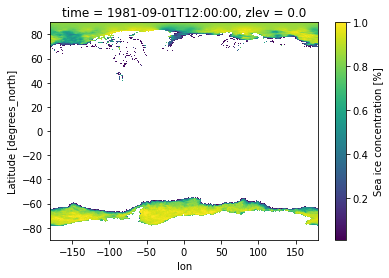

In [15]:
ds.ice[0,0].plot()

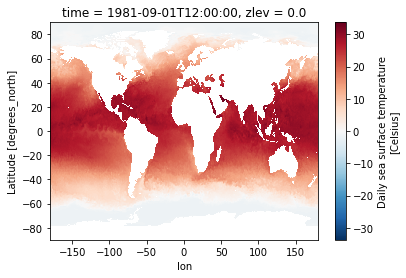

In [16]:
#make sure prime meridian is still at correct location
ds.sst[0,0].plot()

In [54]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

#converting lat from degrees to meters
#delta_lat = grid.diff(ds.lat, 'Y', boundary='fill', fill_value=np.nan)
#just manually create an array of size 720 of 0.25
delta_lat = xr.DataArray(np.array(np.repeat(0.25, 117), dtype='float32'),
                         dims='lat', coords=dict(lat=ds_wg.lat))
dy = delta_lat * meters_per_degree


#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid.diff(ds.lon, 'X', boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds.lat))

In [55]:
dy

<xarray.DataArray (lat: 117)>
array([27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732, 27798.732, 27798.732, 27798.732,
       27798.732, 27798.732, 27798.732], dtype=float32)
Coordinates:
  * lat      (lat) float32 -79.88 -79.62 -79.38 -79.12 ... -51.38 -51.12 -50.88

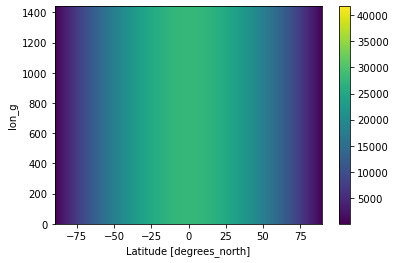

In [18]:
dx.plot()

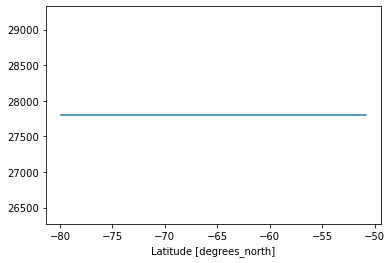

In [56]:
dy.plot()

In [19]:
ds.lat.sel(lat=-51, method='nearest')

<xarray.DataArray 'lat' ()>
array(-50.875, dtype=float32)
Coordinates:
    lat      float32 -50.88
Attributes:
    grids:      Uniform grid from -89.875 to 89.875 by 0.25
    long_name:  Latitude
    units:      degrees_north

In [20]:
ds.lat[157]

<xarray.DataArray 'lat' ()>
array(-50.625, dtype=float32)
Coordinates:
    lat      float32 -50.62
Attributes:
    grids:      Uniform grid from -89.875 to 89.875 by 0.25
    long_name:  Latitude
    units:      degrees_north

In [21]:
dy.lat_g[152]

<xarray.DataArray 'lat_g' ()>
array(152)

In [22]:
ds.lon.sel(lon=30, method='nearest')

<xarray.DataArray 'lon' ()>
array(30.125, dtype=float32)
Coordinates:
    lon      float32 30.12

In [143]:
ds.lon[840]

<xarray.DataArray 'lon' ()>
array(30.375, dtype=float32)
Coordinates:
    lon      float32 30.38

In [128]:
dx.isel(lon_g=slice(458,843)).lon_g

<xarray.DataArray 'lon_g' (lon_g: 385)>
array([  0,   1,   2, ..., 382, 383, 384])
Dimensions without coordinates: lon_g

In [129]:
ds_wg.lon

<xarray.DataArray 'lon' (lon: 386)>
array([-65.   , -64.75 , -64.5  , ...,  30.625,  30.875,  31.125],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -65.0 -64.75 -64.5 -64.25 ... 30.38 30.62 30.88 31.12

In [122]:
dx_wg.lon_g

<xarray.DataArray 'lon_g' (lon_g: 385)>
array([  0,   1,   2, ..., 382, 383, 384])
Dimensions without coordinates: lon_g

In [24]:
#WG boundaries (65˚W, 30˚E; 80˚S, 50˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = -79.875
upper_lat = -50.875
left_lon =  -65
right_lon = 30.125

#use isel for dx dy
lower_lat_g = 40
upper_lat_g = 157
left_lon_g = 458
right_lon_g = 840

#ISEL OMITS LAST VALUE IN SLICE, SEL DOES NOT!

In [25]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat))
lon_range = dict(lon=slice(left_lon, right_lon))

#lat_range_g = dict(lat_g = slice(lower_lat_g, upper_lat_g))
lon_range_g = dict(lon_g = slice(left_lon_g, right_lon_g))

In [58]:
ds_wg = ds.sel(**lat_range, **lon_range)
dx_wg = dx.sel(**lat_range, **lon_range_g)
dy_wg = dy.sel(**lat_range)

In [59]:
dy_wg.shape

(117,)

In [60]:
dx_wg.shape

(382, 117)

In [61]:
ds_wg

,Array,Chunk
Bytes,2.42 GiB,3.41 MiB
Shape,"(14532, 1, 117, 382)","(20, 1, 117, 382)"
Count,5090 Tasks,727 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.42 GiB,3.41 MiB
Shape,"(14532, 1, 117, 382)","(20, 1, 117, 382)"
Count,5090 Tasks,727 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [30]:
ds_wg.ice

,Array,Chunk
Bytes,2.42 GiB,3.41 MiB
Shape,"(14532, 1, 117, 382)","(20, 1, 117, 382)"
Count,5090 Tasks,727 Chunks
Type,float32,numpy.ndarray


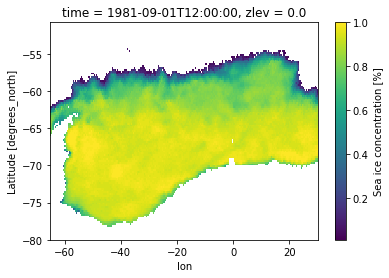

In [31]:
ds_wg.ice[0].plot()

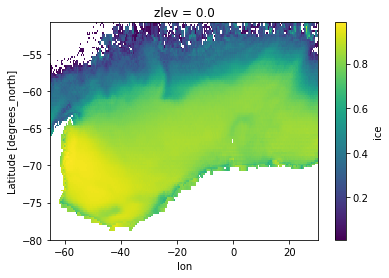

In [32]:
ds_wg.ice.mean(dim='time').plot()

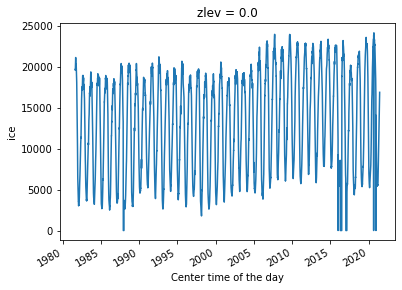

In [33]:
ds_wg.ice.sum(['lat', 'lon']).plot()

In [30]:
ds_wg.ice

,Array,Chunk
Bytes,2.42 GiB,3.41 MiB
Shape,"(14532, 1, 117, 382)","(20, 1, 117, 382)"
Count,5090 Tasks,727 Chunks
Type,float32,numpy.ndarray


In [66]:
ds_wg.ice.lon

<xarray.DataArray 'lon' (lon: 382)>
array([-65.   , -64.75 , -64.5  , ...,  29.625,  29.875,  30.125],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -65.0 -64.75 -64.5 -64.25 ... 29.38 29.62 29.88 30.12

In [74]:
#changing lon_g to lon and adding it as a coordinate object
dx_wg_new = dx_wg.swap_dims({'lon_g':'lon'}).assign_coords(lon=ds_wg.lon)

In [75]:
dx_wg_new

<xarray.DataArray (lon: 382, lat: 117)>
array([[ 4886.9146,  5006.273 ,  5125.536 , ..., 17352.541 , 17447.135 ,
        17541.398 ],
       [ 4886.9146,  5006.273 ,  5125.536 , ..., 17352.541 , 17447.135 ,
        17541.398 ],
       [ 4886.9146,  5006.273 ,  5125.536 , ..., 17352.541 , 17447.135 ,
        17541.398 ],
       ...,
       [ 4886.9146,  5006.273 ,  5125.536 , ..., 17352.541 , 17447.135 ,
        17541.398 ],
       [ 4886.9146,  5006.273 ,  5125.536 , ..., 17352.541 , 17447.135 ,
        17541.398 ],
       [ 4886.9146,  5006.273 ,  5125.536 , ..., 17352.541 , 17447.135 ,
        17541.398 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -79.88 -79.62 -79.38 -79.12 ... -51.38 -51.12 -50.88
  * lon      (lon) float32 -65.0 -64.75 -64.5 -64.25 ... 29.38 29.62 29.88 30.12

In [76]:
weighted_ice = ds_wg.ice * dx_wg_new * dy_wg

In [82]:
weighted_ice

,Array,Chunk
Bytes,2.42 GiB,3.41 MiB
Shape,"(14532, 1, 117, 382)","(20, 1, 117, 382)"
Count,6546 Tasks,727 Chunks
Type,float32,numpy.ndarray


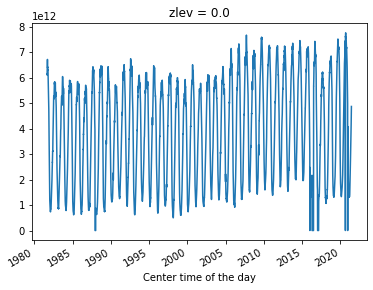

In [78]:
weighted_ice.sum(['lat', 'lon']).plot()

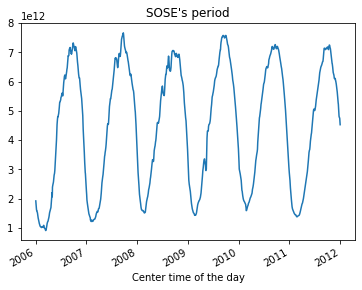

In [88]:
#sose time period
weighted_ice.sel(time=slice('2006', '2011')).sum(['lat', 'lon']).plot()
plt.title("SOSE's period");

In [79]:
ice_anom = weighted_ice.groupby('time.month') - weighted_ice.groupby('time.month').mean()

In [80]:
ice_anom

,Array,Chunk
Bytes,2.42 GiB,3.41 MiB
Shape,"(14532, 1, 117, 382)","(20, 1, 117, 382)"
Count,12905 Tasks,1181 Chunks
Type,float32,numpy.ndarray


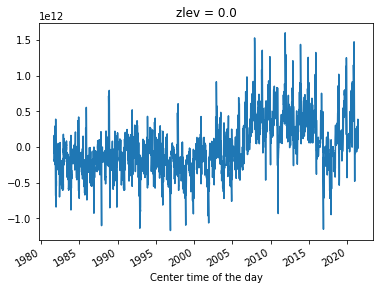

In [81]:
ice_anom.sum(['lat', 'lon']).plot()